In [1]:
import geopy
import gmaps

with open('api.txt') as f:
    API_KEY = f.readline()
    f.close

gmaps.configure(api_key=API_KEY)
itb_coord = (-6.891139157928339, 107.6107663883235)
fig = gmaps.figure(center = itb_coord, zoom_level = 16)
drawing = gmaps.drawing_layer()
fig.add_layer(drawing)
fig



Figure(layout=FigureLayout(height='420px'))

In [2]:
# DISINI BISA BEBAS MELETAKKAN MARKER 
from collections import defaultdict
from pprint import pprint
geocoder = geopy.geocoders.GoogleV3(api_key=API_KEY)
coordinateDict = defaultdict(dict)

a = drawing.features
for marker in a:
    alamat = str(geocoder.reverse(marker.location, exactly_one=True))
    coordinateDict[alamat]['lat'] = marker.location[0]
    coordinateDict[alamat]['lng'] = marker.location[1]

# LIST NAMA TEMPAT BESERTA KOORDINATNYA

In [3]:
# Dianggap semua jalan terhubung semua
import requests 
treeDict = defaultdict(dict)
home = ""
work = ""
url = "https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&"
# get response

for i1, i2 in coordinateDict.items():
    for j1, j2 in coordinateDict.items():
        if(i1 != j1):
            r = requests.get(url + "origins=" + i1 + "&destinations=" + j1 + "&key=" + API_KEY) 
            distance = r.json()["rows"][0]["elements"][0]["distance"]["value"]
            treeDict[i1][j1] = distance

In [7]:
# Modul A*
def Astar(start, goal):
    heuristicDict = createHeuristicDict(goal)
    cost = {start : 0}
    """
    Input : dictionary (data structures for graph with adjacency matrix representation) 
    Output : Array of nodes with A* values , Array of ordered place sequence based on shortest path using A* pathfinder algortihm
    """
    # OPEN SET
    opened = []
    # CLOSE SET
    closed = []
    # CURRENT PLACE
    current = start
    # ADD CURRENT TO OPEN 
    opened.append([current, heuristicDict[current]])
    while True:
        # CHECK FOR MINIMUM HEURISTIC in OPEN SET
        current = min(opened, key = lambda x : x[1])
        # CHECKED_NODE
        checked_node = current[0]
        # APPEND IT TO CLOSED SET
        closed.append(current)
        # AFTER APPENDING TO CLOSE, DELETE FROM OPENED
        opened.remove(current)
        # CHECK IF GOAL IS INCLUDED IN CLOSED SET
        if(closed[-1][0] == goal):
            break
        # IF THE PREVIOUS CONDITIONAL GUARD IS NOT FULFILLED, move to the next children's node
        for children in treeDict[checked_node].items():
            # CHECK IF CHILDREN NODES ALREADY IN CLOSED SET
            if children[0] in [closed_nodes[0] for closed_nodes in closed]:
                 continue
            # UPDATE THE CHILDREN PATH WITH RECENT VALUE, guaranteed minimum because of lambda minimum function in line 24
            cost.update({children[0] : cost[checked_node] + children[1]})
            # CAST F VALUE (HEURISTIC + CURRENT PATH COST) OF CURRENT NODES
            current_fval = cost[checked_node] + heuristicDict[children[0]] + children[1]
            # ADD TO OPENED AFTER COUNTING THE F VALUES
            # USED TEMP SO THE ACTION WON'T CORRUPT THE treeDict
            temp = [children[0], current_fval]
            opened.append(temp)
    ''' ordering the sequence based on A* values
    e.g of A* closed set = [['ITB', 65], ['DagoA', 70], ['DagoB', 70], ['DagoC', 70], ['Goal', 75]] '''
    # DEFINING THE LAST_NODE OR GOAL_NODE
    last_node = goal
    ordered_sequence = []
    ordered_sequence.append(goal)
    # TRACK FROM lastindex-1 to the first index 
    for i in range(len(closed) - 2, -1, -1):
        # DEFINE CHECKED NODE AS STRING 
        check_node = closed[i][0]
        # CHECK IF THE GOAL IS THE CHILD OF THE CHECKED NODE
        if last_node in [children[0] for children in treeDict[check_node].items()]:
            if (cost[check_node] + treeDict[check_node][last_node] == cost[last_node]):
                ordered_sequence.append(check_node)
                last_node = check_node
    # Reverse ordering from ordered_sequence
    ordered_sequence.reverse()
    return closed, ordered_sequence, cost

def createHeuristicDict(goal):
    heuristicDict2 = dict()
    for nodes in treeDict:
        heuristicDict2[nodes] = euclideanDistance(nodes, goal)
    return heuristicDict2
    
# HAVERSINE FORMULA
from math import radians, cos, sin, asin, sqrt
def euclideanDistance(start, end):
    lon1 = coordinateDict[start]["lng"]
    lat1 = coordinateDict[start]["lat"]
    lon2 = coordinateDict[end]["lng"]
    lat2 = coordinateDict[end]["lat"]
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [24]:
#GRAPH MAKER
import networkx as nx
import matplotlib.pyplot as plt
def graphMaker(start, goal):
    # Inisialisasi Graph
    G = nx.Graph()
    # Initialize variables from PathFinder
    visited_graph, ordered_sequence, cost_function = Astar(start, goal)
    # Jarak
    distance_sum = 0
    for i in range(len(ordered_sequence) - 1):
        distance_sum += treeDict[ordered_sequence[i]][ordered_sequence[i + 1]]
    # Bentuk semua nodes
    for nodes in treeDict:
        G.add_node(nodes, pos = (coordinateDict[nodes]['lat'], coordinateDict[nodes]['lng']))
    # Bentuk semua edges
    for nodes in treeDict:
        for children in treeDict[nodes]:
            G.add_edge(nodes, children, weight = treeDict[nodes][children])
    
    # Posisi
    pos = nx.get_node_attributes(G, 'pos')
    # Bobot
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G,pos, edge_labels= labels)
    # Mewarnai node yang dikunjungi
    node_color = []
    for node in G.nodes:
        if node in ordered_sequence:
            node_color.append("red")
        else :
            node_color.append("blue")
        
    nx.draw(G, pos , with_labels = True, node_size = 1200,  node_color = node_color)
    for i in range(len(ordered_sequence)):
        if(i != len(ordered_sequence) - 1):
            print(f"{ordered_sequence[i]} =>", end = " ")
        else:
            print(ordered_sequence[i])
    print()
    print()
    print(f"Panjang lintasan adalah {distance_sum} METER")
    plt.figure(figsize=(40,40)) 
    plt.show()
    return ordered_sequence

In [25]:
# DAFTAR KOTA YANG AKAN DITUJU
listKota = []
for namaKota, coordinate in coordinateDict.items():
    print(namaKota)
    listKota.append(namaKota)

Jl. Ir. H. Juanda No.77, Lb. Siliwangi, Kecamatan Coblong, Kota Bandung, Jawa Barat 40132, Indonesia
Jl. Pahlawan No.44, Cikutra, Kec. Cibeunying Kidul, Kota Bandung, Jawa Barat 40122, Indonesia
Jl. Ir. H. Juanda No.127, Lb. Siliwangi, Kecamatan Coblong, Kota Bandung, Jawa Barat 40132, Indonesia
Jl. Dipati Ukur No.117, Lebakgede, Kecamatan Coblong, Kota Bandung, Jawa Barat 40132, Indonesia
Jl. Ciumbuleuit No.2, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia
Jl. Cihampelas No.85, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia
Jl. Cihampelas No.165, RT.02, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia


Jl. Ciumbuleuit No.2, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia => Jl. Cihampelas No.165, RT.02, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia


Panjang lintasan adalah 803 METER


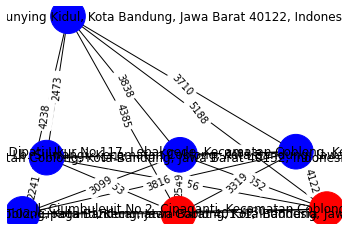

<Figure size 2880x2880 with 0 Axes>

['Jl. Ciumbuleuit No.2, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia', 'Jl. Cihampelas No.165, RT.02, Cipaganti, Kecamatan Coblong, Kota Bandung, Jawa Barat 40131, Indonesia']


In [26]:
# Input tempat awal
string_awal = str(input("Masukkan tempat awal : "))
while(string_awal not in listKota):
    print("Salah memasukkan nama tempat awal")
    string_awal = str(input("Masukkan tempat awal : "))
# Input tempat akhir
string_akhir = str(input("Masukkan tempat akhir : "))
while(string_akhir not in listKota):
    print("Salah memasukkan nama tempat akhir")
    string_akhir = str(input("Masukkan tempat awal : "))
a = graphMaker(string_awal, string_akhir)
print(a)

In [33]:
# GAMBAR BALIK KE BENTUK MAP

locations = []
for sequence in a:
    locations.append((coordinateDict[sequence]['lat'], coordinateDict[sequence]['lng']))
fig = gmaps.figure(center = locations[0], zoom_level = 16)
marker_layer = gmaps.marker_layer(locations)
fig.add_layer(marker_layer)
i = 1
for markers in marker_layer.markers:
    markers.label = f"STEP {i}"
    i += 1

fig
# DiWAKILKAN DENGAN LABEL STEP untuk urutan penelusuran

Figure(layout=FigureLayout(height='420px'))